In [1]:
import os, sys
from glob import glob
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.interpolate import interp1d, RegularGridInterpolator
from tqdm import *

import pickle

import seaborn as sns

from scipy.integrate import quad

from grf.grf import TransitionProbabilities, PerturbedProbability, FIRAS
from grf.units import *
from grf.pk_interp import PowerSpectrumGridInterpolator

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load plot style

from plot_params import params
del params['backend.qt4']
del params['backend.qt5']

pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


# Preamble

## Load pre-computed matter power spectra

In [3]:
# Non-linear matter power spectrum. 
pspec_nonlin_matter       = PowerSpectrumGridInterpolator("nonlin_matter")
# Non-linear baryon power spectrum from simulations, lower limit. 
pspec_nonlin_baryon_lower = PowerSpectrumGridInterpolator("franken_lower")
# Non-linear baryon power spectrum from simulations, upper limit. 
pspec_nonlin_baryon_upper = PowerSpectrumGridInterpolator("franken_upper")

## Load class with spectral and PDF information

In [4]:
# Class containing results with non-linear matter power spectrum. 
firas_nonlin            = FIRAS(pspec_nonlin_matter)
# Class containing results with non-linear baryon power spectrum from simulations, lower limit.
firas_nonlin_baryon_low = FIRAS(pspec_nonlin_baryon_lower)
# Class containing results with non-linear baryon power spectrum from simulations, upper limit. 
firas_nonlin_baryon_upp = FIRAS(pspec_nonlin_baryon_upper)

# Analytic PDF. 
log_analytic_pdf_interp = pickle.load(open('../data/analytic_pdf_grids/log_analytic_pdf_interp.npy', 'rb'))

../grf/grf.py:633: FutureWarning: read_table is deprecated, use read_csv instead.
  names=['freq', 'I', 'residual', 'uncert', 'poles'])


# Dark photon dark matter energy deposited per baryon (LOCAL)

## Extract the energy per baryon from DM conversion

In [5]:
# Critical density, in g/cm^3. 
rho_crit = firas_nonlin.cosmo.critical_density(0).value
# Omega_DM.
Omega_DM = firas_nonlin.cosmo.Odm0

# Number density of baryons in keV^3. 
n_b_in_keV3 = firas_nonlin.n_b(0) * KeV**3

# Conversion factor from g/cm^3 to keV^4
conv_fac = 4.31846e6 * KeV**4

# Energy density of DM in keV^4. 
rho_DM = Omega_DM*rho_crit * conv_fac

# Energy per baryon, if energy in all DM were completely absorbed by baryons.
energy_per_baryon = rho_DM/n_b_in_keV3

## Compute homogeneous conversion probability and maximum $\epsilon$

In [6]:
# Compute the homogeneous conversion probability. 

# Compute the lowest and highest mass for which homogeneous
# resonance occurs in the range 2 < z < 6.

# These are extremely low mass A', way below the first FIRAS bin. 
# We can set omega = 0 to obtain this mass range.
low_m_Ap = np.sqrt(firas_nonlin.m_A_sq(1.9, 0.)) 
upp_m_Ap = np.sqrt(firas_nonlin.m_A_sq(6.1, 0.)) 

# Range of masses to compute the homogeneous transition probabilities. 
# Mass in natural units of the code: keV.
m_Ap_homo_ary = np.logspace(np.log10(low_m_Ap), np.log10(upp_m_Ap), 100)

# Obtain P/eps^2. 
P_over_eps2_homo_ary = np.array(
    [firas_nonlin.P_tot([m_Ap], 1., m_Ap, evolve_z=False)[2][0][0] for m_Ap in tqdm_notebook(m_Ap_homo_ary)]
)

# Obtain the maximum epsilon.
eps_max_homo_ary = np.sqrt(1.*eV/(P_over_eps2_homo_ary * energy_per_baryon))
# Set all values not in 2 < z < 6 to 2 to produce a cut-off. 
# Set this by testing m_Ap against the plasma mass at z = 2 and z = 6.
eps_max_homo_ary[m_Ap_homo_ary < np.sqrt(firas_nonlin.m_A_sq(2., 0.))] = 2. 
eps_max_homo_ary[m_Ap_homo_ary > np.sqrt(firas_nonlin.m_A_sq(6., 0.))] = 2. 

# Rescale m_Ap_homo_ary to eV.
m_Ap_homo_ary /= eV

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## Function for Lyman Alpha Cut-Off

In [7]:
# For large under-/overdensities, the Lyman-alpha flux is not sensitive to the temperature in those regions.
# For overdensities, this is clear, because if a Ly-a source is in an overdense region, the Ly-a radiation 
# cannot escape the overdensity. For underdensities, this is less clear to me. 

def lyman_alpha_cut(z):
    
    z_raw = np.array([2., 3., 4., 5., 6.])
    log_one_plus_delta_low_raw = np.log10([4.18e-1, 1.38e-1, 5.83e-2, 2.68e-2, 1.56e-2])
    log_one_plus_delta_upp_raw = np.log10([25.01, 8.13, 3.44, 1.60, 0.925])
    
    one_plus_delta_low = 10**np.interp(z, z_raw, log_one_plus_delta_low_raw)
    one_plus_delta_upp = 10**np.interp(z, z_raw, log_one_plus_delta_upp_raw)
    
    return one_plus_delta_low, one_plus_delta_upp

## Compute inhomogeneous conversion probability and maximum $\epsilon$

In [8]:
# Compute the inhomogeneous conversion probability. 

# Redshift and m_A' arrays.
z_ary = np.logspace(np.log10(2), np.log10(6), 200)
m_Ap_ary = np.logspace(-14, -12, 200)

# Probability/eps^2 for different choice of PDFs / power spectra. 
# Store as dictionary for more 

P_over_eps2_dict = {
    'analytic_fid': None, 'lognormal_low_fid': None
}

one_plus_delta_dict = dict(P_over_eps2_dict)

pdf_dict = dict(P_over_eps2_dict)

eps_max_dict = dict(P_over_eps2_dict)

b_dict = dict.fromkeys(P_over_eps2_dict.keys(), 1.)

for key in P_over_eps2_dict:
    
    P_over_eps2_dict[key] = np.zeros_like(m_Ap_ary)
    one_plus_delta_dict[key] = lyman_alpha_cut
    
for key in ['analytic_fid']:
    
    pdf_dict[key] = log_analytic_pdf_interp
    
for key in ['lognormal_low_fid']:
    
    pdf_dict[key] = 'lognormal'
    
for i,m_Ap in enumerate(tqdm_notebook(m_Ap_ary)):
    
    for key in P_over_eps2_dict:
        
        if key != 'lognormal_b_1_5_low':
        
            P_over_eps2_dict[key][i] = np.array(
                firas_nonlin_baryon_low.P_tot_perturb(
                    omega=[m_Ap * eV], eps=1., m_Ap=m_Ap * eV,
                    pdf=pdf_dict[key], 
                    z_int = [2, 6], b = b_dict[key],
                    one_plus_delta_bound=one_plus_delta_dict[key], Ap_DM=True, 
                    eng_weight=False, n_z_bins=1000
                )[2]
            )[0]
            
        else:
            
            P_over_eps2_dict[key][i] = np.array(
                firas_nonlin.P_tot_perturb(
                    omega=[m_Ap * eV], eps=1., m_Ap=m_Ap * eV,
                    pdf=pdf_dict[key], 
                    z_int = [2, 6], b = b_dict[key],
                    one_plus_delta_bound=one_plus_delta_dict[key], Ap_DM=True, 
                    eng_weight=False, n_z_bins=1000
                )[2]
            )[0]


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [9]:
for key in eps_max_dict:
    
    eps_max_dict[key] = np.sqrt(1.*eV/(P_over_eps2_dict[key]  * energy_per_baryon))
    eps_max_dict[key][eps_max_dict[key] > 1.] = 2.


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


## Load existing experimental limits

In [10]:
delta_rho_cdm_limit   = np.loadtxt('../data/existing_constraints/delta_rho_cdm.csv', delimiter=',')
He_nonres_limit       = np.loadtxt('../data/existing_constraints/He_nonres.csv', delimiter=',')
mu_y_distortion_limit = np.loadtxt('../data/existing_constraints/mu_y_distortion.csv', delimiter=',')
DM_Radio_limit        = np.loadtxt('../data/existing_constraints/DM_Radio.csv', delimiter=',')
dark_ages_limit       = np.loadtxt('../data/existing_constraints/dark_ages_resonant_conv.csv', delimiter=',')


delta_rho_cdm_interp   = interp1d(delta_rho_cdm_limit[:,0],   delta_rho_cdm_limit[:,1],   bounds_error=False, fill_value=2.)
He_nonres_interp       = interp1d(He_nonres_limit[:,0],       He_nonres_limit[:,1],       bounds_error=False, fill_value=2.)
mu_y_distortion_interp = interp1d(mu_y_distortion_limit[:,0], mu_y_distortion_limit[:,1], bounds_error=False, fill_value=2.)
dark_ages_interp       = interp1d(dark_ages_limit[:,0],       dark_ages_limit[:,1],       bounds_error=False, fill_value=2.)


def existing_DP_DM_limits(m_Ap):
    
    lim_He_nonres       = He_nonres_interp(m_Ap)
    lim_mu_y_distortion = mu_y_distortion_interp(m_Ap)
    
    return np.minimum.reduce([lim_He_nonres, lim_mu_y_distortion])

def homo_DP_DM_limits(m_Ap):
    
    lim_dark_ages       = dark_ages_interp(m_Ap)
    lim_delta_rho_cdm   = delta_rho_cdm_interp(m_Ap)
    
    return np.minimum.reduce([lim_dark_ages, lim_delta_rho_cdm])


## Make fiducial constraints plot

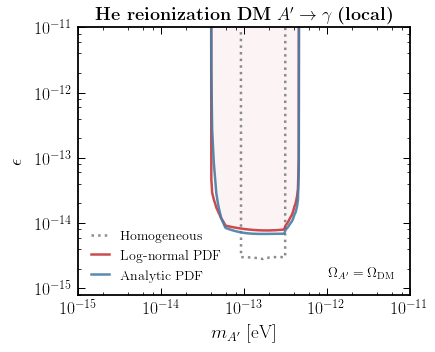

In [11]:
fig, ax=plt.subplots(figsize=(8 / 1.3, 6.5 / 1.3))

plt.loglog()

plt.plot(m_Ap_homo_ary, eps_max_homo_ary, color='gray', linestyle=':', label='Homogeneous')

plt.gca().set_prop_cycle(None)

plt.plot(m_Ap_ary, eps_max_dict['lognormal_low_fid'], color=cols_default[0], label="Log-normal PDF")

plt.plot(m_Ap_ary, eps_max_dict['analytic_fid'], label=r'Analytic PDF')

plt.fill_between(
    m_Ap_ary, 
    np.maximum.reduce(
        np.transpose([eps_max_dict['lognormal_low_fid'], eps_max_dict['analytic_fid']])
        , axis=1
    ), 2,
    color=cols_default[0], alpha=0.05
)

m_Ap_ary_extended = np.logspace(-17, -8, 200)

plt.fill_between(m_Ap_ary_extended, existing_DP_DM_limits(m_Ap_ary_extended), 2, alpha=0.15, color=cols_default[6])

# plt.plot(m_Ap_ary_extended, homo_DP_DM_limits(m_Ap_ary_extended), alpha=0.25, ls = ':', color=cols_default[6])

plt.plot(DM_Radio_limit[:,0], DM_Radio_limit[:,1], ls='-.', c=cols_default[4], lw=1)

# plt.text(0.79, 0.905, 'Existing \n Constraints', horizontalalignment='center', transform=ax.transAxes, color=cols_default[6])
# plt.text(
#     0.82, 0.655, 'DM Radio \n (projection)', 
#     ha='center', transform=ax.transAxes, rotation=-37, color=cols_default[4]
# )
plt.text(
    0.95, 0.06, r'$\Omega_{A^\prime} = \Omega_{\mathrm{DM}}$', 
    horizontalalignment='right', transform=ax.transAxes,
    fontsize=14
)


plt.legend(ncol=1, fontsize=14, handlelength=1.3, loc='lower left')

plt.title(r'\textbf{He reionization DM} $A^\prime \to \gamma$ \textbf{(local)}')

plt.xlabel(r'$m_{A^\prime}$ [eV]')
plt.ylabel(r'$\epsilon$')

# plt.axis([1e-15, 1e-10, 5e-17, 1e-8])
plt.axis([1e-15, 1e-11, 8e-16, 1e-11])

# Tick tweaks 

from matplotlib import ticker

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()

plt.savefig('../paper/draft-letter/plots/limit_DP_DM_local.pdf')

